# Import libraries

In [1]:
# Manipulate date
import pandas as pd 
import numpy as np
# Visualize data 
import matplotlib.pyplot as plt
# Model
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from tensorflow.keras.models import model_from_json
from keras.layers import Dense, Flatten,Conv2D , MaxPool2D, BatchNormalization, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Performance metrics
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing import image

2023-03-14 19:52:30.129403: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Train test split

In [2]:
# Train data
train_data = ImageDataGenerator(
    rescale=1./255, # Re-scale pictures from 0 to 1
    validation_split=0.2, # Train/test split
    rotation_range=10, # Images are randomly rotated up to 10 degrees
    shear_range = 0.2, # Images are radomly sheared up to specific value
    zoom_range = 0.2, # Images are randomly zoomed up to specific value
    horizontal_flip = True,) 

In [3]:
train_data  = train_data.flow_from_directory(
    '/Users/pabloalonsomedrano/Desktop/Eurosat/2750',
    target_size=(64,64),
    batch_size=200,
    class_mode='sparse',
    shuffle=True,
    seed=42,
    subset='training')

Found 21600 images belonging to 10 classes.


In [4]:
# Test data
test_data = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

In [5]:
test_data = test_data.flow_from_directory(
    '/Users/pabloalonsomedrano/Desktop/Eurosat/2750',
    target_size=(64,64),
    batch_size=200,
    class_mode='sparse',
    shuffle=True,
    seed=42,
    subset='validation'
)

Found 5400 images belonging to 10 classes.


# Model creation

A `Convolutional Neural Network` consists of two parts:

* `Base` which is used to extract features from an image

* `Head` determines the class of the image

When creating a model we have two options:

1. Transfer learning: uisng a model that has already been built. (VGG16, VGG19, ResNet50)

2. Creating a model from scratch. 

A. `Pre-trained model`

In [6]:
# pre-trained model: requires images to be in the shape of (224,224)
pretrained_model  = tf.keras.applications.vgg16.VGG16()

pretrained_model.trainable = False

2023-03-14 19:52:32.855115: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
model_1 = keras.Sequential([
    #pre_trained base
    pretrained_model,
    #Head
    Flatten(),
    Dense(32, activation='relu'),
    Dense(10, activation='sigmoid'),
])

 B. `Model from scratch`

`Convolutional Neural Networks` use two type of layers:

1. `Conv2D` applies a filter(kernel) to the input images to create a feature map, helping identify patterns in data. 

* `filters` the number of output filters

* `kernel_size` height and widith

* `kernel_size` height and widht of the convolutioning window

* `stride` distance the window moves at each step in both directions, high quality (1,1)

* `padding` what to do at the boundaries of the input.


2. `MaxPool2D` condenses the feature maps to enhance the features.

* `pool_size` height and width of the pooling wind

* Also includes stride and padding

In [8]:
# Create the model
model = keras.Sequential([

    # First Convolutional Block 
    BatchNormalization(),
    Conv2D(filters=32, kernel_size=5, activation="relu", padding='same',
                  input_shape=[64,64, 3]), #[height, width, color channels(RGB)]
    MaxPool2D(pool_size = 2,strides=5,padding = 'same'),

    # Second Convolutional Block
    BatchNormalization(),
    Conv2D(filters=64, kernel_size=5, activation="relu", padding='same'),
    MaxPool2D(pool_size = 2,strides=5,padding = 'same'),

    # Classifier Head
    Flatten(),
    Dense(units=32, activation="relu"),
    Dense(units=10, activation="softmax"),
])

In [9]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, 
                                                  patience=20,restore_best_weights=True)

In [10]:
# Compile the model
model.compile(
    optimizer= 'adam',
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy'],
)

In [11]:
history = model.fit(
    train_data,
    validation_data= [test_data],
    epochs=15,
    batch_size = 200, 
    verbose=1,
)

Epoch 1/15
108/108 [==============================] - 43s 393ms/step - loss: 1.1672 - sparse_categorical_accuracy: 0.5821 - val_loss: 2.7699 - val_sparse_categorical_accuracy: 0.1172
Epoch 2/15
108/108 [==============================] - 47s 432ms/step - loss: 0.8433 - sparse_categorical_accuracy: 0.6912 - val_loss: 2.2751 - val_sparse_categorical_accuracy: 0.3030
Epoch 3/15
108/108 [==============================] - 49s 451ms/step - loss: 0.7289 - sparse_categorical_accuracy: 0.7368 - val_loss: 1.3303 - val_sparse_categorical_accuracy: 0.5020
Epoch 4/15
108/108 [==============================] - 50s 464ms/step - loss: 0.6688 - sparse_categorical_accuracy: 0.7606 - val_loss: 1.0941 - val_sparse_categorical_accuracy: 0.6206
Epoch 5/15
108/108 [==============================] - 52s 484ms/step - loss: 0.6223 - sparse_categorical_accuracy: 0.7770 - val_loss: 0.9545 - val_sparse_categorical_accuracy: 0.6941
Epoch 6/15
108/108 [==============================] - 59s 541ms/step - loss: 0.5846 -

# Performance

Minimum validation loss: 0.577491819858551


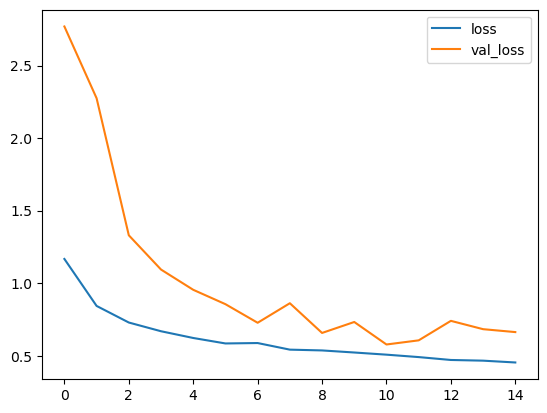

In [12]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

Maximum accuracy: 0.8118518590927124


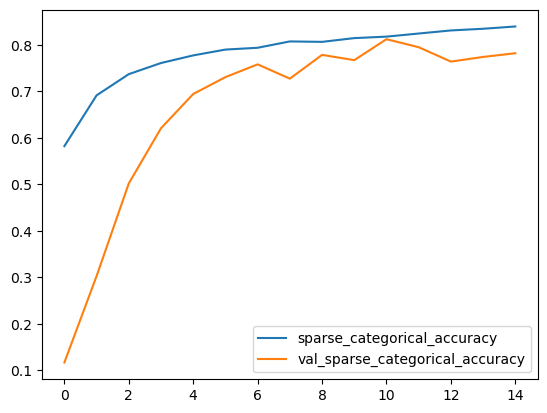

In [13]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy']].plot();
print("Maximum accuracy on the Test set: {}".format(history_df['val_sparse_categorical_accuracy'].max()))

In [14]:
# Save the model
model.save("my_model")

INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets
